## RISK SEGMENTATION & RETENTION STRATEGY
Apply our best churn prediction model to all 7,043 customers and create actionable risk categories for targeted retention campaigns.
### Risk Categories Defined
* HIGH RISK (Top 10-15%): Immediate retention action required
* MEDIUM RISK (Next 20-25%): Monitor and nurture
* LOW RISK (Bottom 65-70%): Maintain current service levels

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import LabelEncoder

# Load the model
with open('../outputs/churn_model.pkl', 'rb') as f:lr_model = pickle.load(f)

# Load the feature names
with open('../outputs/feature_names.pkl', 'rb') as f:feature_names = pickle.load(f)

print(f" Features: {len(feature_names)}")
print(f"\nModel type: {type(lr_model).__name__}")


 Features: 19

Model type: LogisticRegression


### 1,Which customer data will we use to generate risk scores for all accounts?

In [4]:
df = pd.read_csv('../data/Telco-Customer-Churn.csv')
print(f"Dataset: {len(df):,} customers")
print(f"  Features: {df.shape[1]}")
print(f"\nSample data:")
print(df[['customerID', 'Contract', 'tenure', 'MonthlyCharges', 'Churn']].head(3))


Dataset: 7,043 customers
  Features: 21

Sample data:
   customerID        Contract  tenure  MonthlyCharges Churn
0  7590-VHVEG  Month-to-month       1           29.85    No
1  5575-GNVDE        One year      34           56.95    No
2  3668-QPYBK  Month-to-month       2           53.85   Yes


### 2,How do we prepare all customer data to match our trained model's expected format?

In [5]:
#   data for prediction
df_encoded = df.copy()

# Convert TotalCharges to numeric
df_encoded['TotalCharges'] = pd.to_numeric(df_encoded['TotalCharges'], errors='coerce')
df_encoded['TotalCharges'].fillna(0, inplace=True)

# Label
label_encoders = {}
categorical_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('customerID')
if 'Churn' in categorical_cols:
    categorical_cols.remove('Churn')

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le
X_all = df_encoded.drop(['customerID', 'Churn'], axis=1)
print(f"  Shape: {X_all.shape}")
print(f"  Features match model: {list(X_all.columns) == feature_names}")


  Shape: (7043, 19)
  Features match model: True


### 3,How do we generate churn risk scores and categorize all customers by risk level?

In [6]:
#Score of customers with churn probability
churn_probabilities = lr_model.predict_proba(X_all)[:, 1]  
churn_predictions = lr_model.predict(X_all)  

# results
risk_df = pd.DataFrame({'customerID': df['customerID'],'Churn_Probability': (churn_probabilities * 100).round(1),'Risk_Score': churn_predictions,'Actual_Churn': df['Churn']})

# risk categories
def categorize_risk(prob):
    if prob >= 70:
        return 'High Risk'
    elif prob >= 40:
        return 'Medium Risk'
    else:
        return 'Low Risk'

risk_df['Risk_Category'] = risk_df['Churn_Probability'].apply(categorize_risk)


print(f"\nRisk Distribution:")
print(risk_df['Risk_Category'].value_counts())
print(f"\n Sample predictions:")
print(risk_df.head(10))



Risk Distribution:
Risk_Category
Low Risk       4938
Medium Risk    1669
High Risk       436
Name: count, dtype: int64

 Sample predictions:
   customerID  Churn_Probability  Risk_Score Actual_Churn Risk_Category
0  7590-VHVEG               58.3           1           No   Medium Risk
1  5575-GNVDE                5.3           0           No      Low Risk
2  3668-QPYBK               32.1           0          Yes      Low Risk
3  7795-CFOCW                2.9           0           No      Low Risk
4  9237-HQITU               67.0           1          Yes   Medium Risk
5  9305-CDSKC               78.2           1          Yes     High Risk
6  1452-KIOVK               52.7           1           No   Medium Risk
7  6713-OKOMC               33.2           0           No      Low Risk
8  7892-POOKP               59.3           1          Yes   Medium Risk
9  6388-TABGU                1.0           0           No      Low Risk


### 4,How can we visualize customer risk distribution for stakeholder communication?

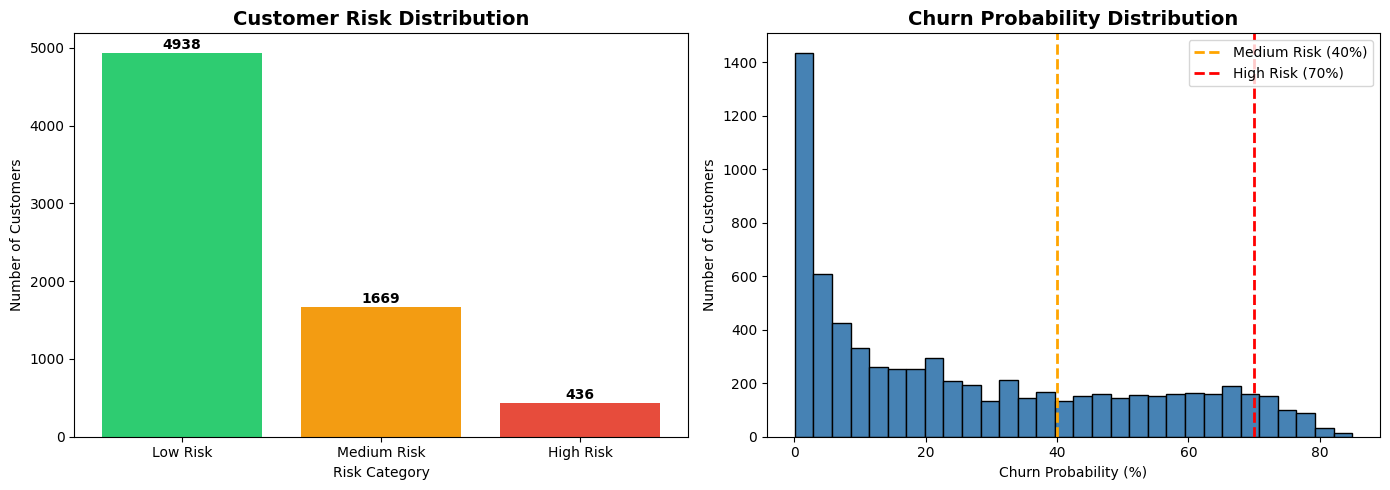

 Visualization saved


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1
risk_counts = risk_df['Risk_Category'].value_counts()
colors = ['#2ecc71', '#f39c12', '#e74c3c'] 
axes[0].bar(risk_counts.index, risk_counts.values, color=colors)
axes[0].set_title('Customer Risk Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Customers')
axes[0].set_xlabel('Risk Category')
for i, v in enumerate(risk_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Plot 2: Churn probability distribution
axes[1].hist(risk_df['Churn_Probability'], bins=30, color='steelblue', edgecolor='black')
axes[1].axvline(40, color='orange', linestyle='--', linewidth=2, label='Medium Risk (40%)')
axes[1].axvline(70, color='red', linestyle='--', linewidth=2, label='High Risk (70%)')
axes[1].set_title('Churn Probability Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Churn Probability (%)')
axes[1].set_ylabel('Number of Customers')
axes[1].legend()

plt.tight_layout()
plt.savefig('../outputs/risk_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Visualization saved")


### 5,What characterizes our highest-risk customers who need immediate retention action?

In [8]:
# Analyze high risk customers
high_risk = risk_df[risk_df['Risk_Category'] == 'High Risk']

print(f"HIGH RISK CUSTOMERS: {len(high_risk):,}")
print(f"------({len(high_risk)/len(risk_df)*100:.1f}% of total customers)\n")

# Merge with original data 
high_risk_details = high_risk.merge(df, on='customerID')

print("HIGH RISK CUSTOMER PROFILE:")
print("="*50)
print("\n1. Contract Type:")
print(high_risk_details['Contract'].value_counts())
print("\n2. Average Tenure:")
print(f"   {high_risk_details['tenure'].mean():.1f} months (vs overall avg: {df['tenure'].mean():.1f})")
print("\n3. Average Monthly Charges:")
print(f"   ${high_risk_details['MonthlyCharges'].mean():.2f} (vs overall avg: ${df['MonthlyCharges'].mean():.2f})")
print("\n4. Internet Service:")
print(high_risk_details['InternetService'].value_counts())
print("\n5. Payment Method:")
print(high_risk_details['PaymentMethod'].value_counts().head(3))
print("\n" + "|"*50)
print("Top 10 highest risk customers:")
print(high_risk.nlargest(10, 'Churn_Probability')[['customerID', 'Churn_Probability', 'Risk_Category']])


HIGH RISK CUSTOMERS: 436
------(6.2% of total customers)

HIGH RISK CUSTOMER PROFILE:

1. Contract Type:
Contract
Month-to-month    436
Name: count, dtype: int64

2. Average Tenure:
   6.2 months (vs overall avg: 32.4)

3. Average Monthly Charges:
   $86.47 (vs overall avg: $64.76)

4. Internet Service:
InternetService
Fiber optic    428
DSL              8
Name: count, dtype: int64

5. Payment Method:
PaymentMethod
Electronic check           352
Mailed check                41
Credit card (automatic)     25
Name: count, dtype: int64

||||||||||||||||||||||||||||||||||||||||||||||||||
Top 10 highest risk customers:
      customerID  Churn_Probability Risk_Category
3380  5178-LMXOP               84.9     High Risk
2208  7216-EWTRS               84.4     High Risk
4800  9300-AGZNL               84.1     High Risk
5989  5567-WSELE               84.0     High Risk
1976  9497-QCMMS               83.9     High Risk
3159  5150-ITWWB               83.8     High Risk
3749  4424-TKOPW             

### 6,What specific retention actions should we take for each risk category to protect revenue?

In [ ]:
print(" BUSINESS ACTION PLAN")
print("*"*60)

# financial impact
high_risk_count = len(risk_df[risk_df['Risk_Category'] == 'High Risk'])
medium_risk_count = len(risk_df[risk_df['Risk_Category'] == 'Medium Risk'])

#  monthly charges
action_df = risk_df.merge(df[['customerID', 'MonthlyCharges', 'Contract', 'tenure']], on='customerID')

high_risk_revenue = action_df[action_df['Risk_Category'] == 'High Risk']['MonthlyCharges'].sum()
medium_risk_revenue = action_df[action_df['Risk_Category'] == 'Medium Risk']['MonthlyCharges'].sum()

print(f"\n HIGH RISK ({high_risk_count:,} customers)")
print(f" Monthly revenue at risk: ${high_risk_revenue:,.2f}")
print(f" Annual revenue at risk: ${high_risk_revenue * 12:,.2f}")
print(f"\nACTIONS:")
print(f" ------- Immediate outreach by retention team")
print(f"---------Offer 20% discount for 1-year contract upgrade")
print(f"---------Assign dedicated account manager")
print(f"---------Priority customer support access")
print("*"*60)
print(f"\n MEDIUM RISK ({medium_risk_count:,} customers)")
print(f"Monthly revenue at risk: ${medium_risk_revenue:,.2f}")
print(f"Annual revenue at risk: ${medium_risk_revenue * 12:,.2f}")
print(f"\nACTIONS:")
print(f"----------Send satisfaction survey")
print(f"----------Offer 10% discount for contract extension")
print(f"----------Promote additional services (bundle deals)")
print(f"----------Quarterly check-in emails")
print("*"*60)
print(f"\n LOW RISK")
print(f"ACTIONS:")
print(f"----------Maintain service quality")
print(f"----------Upsell premium services")
print(f"----------Request referrals")

print("\n" + "="*60)

# Export high risk customers
high_risk_export = action_df[action_df['Risk_Category'] == 'High Risk'][['customerID', 'Churn_Probability', 'Contract', 'tenure', 'MonthlyCharges']].sort_values('Churn_Probability', ascending=False)

high_risk_export.to_csv('../outputs/high_risk_customers.csv', index=False)
print(f"✓Total customers: {len(high_risk_export):,}")


 BUSINESS ACTION PLAN
************************************************************

 HIGH RISK (436 customers)
 Monthly revenue at risk: $37,700.30
 Annual revenue at risk: $452,403.60

ACTIONS:
 ------- Immediate outreach by retention team
---------Offer 20% discount for 1-year contract upgrade
---------Assign dedicated account manager
---------Priority customer support access
************************************************************

 MEDIUM RISK (1,669 customers)
Monthly revenue at risk: $128,083.90
Annual revenue at risk: $1,537,006.80

ACTIONS:
----------Send satisfaction survey
----------Offer 10% discount for contract extension
----------Promote additional services (bundle deals)
----------Quarterly check-in emails
************************************************************

 LOW RISK
ACTIONS:
----------Maintain service quality
----------Upsell premium services
----------Request referrals

✓ Total customers: 436


### 7,How well does our model perform when applied to all 7,043 customers?

In [12]:
# Model performance on full dataset
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Get actual churn values (0 or 1)
y_all = (df['Churn'] == 'Yes').astype(int)

#  metrics
conf_matrix = confusion_matrix(y_all, churn_predictions)
auc_score = roc_auc_score(y_all, churn_probabilities)

# Classification report
class_report = classification_report(y_all, churn_predictions, target_names=['Stay', 'Churn'], output_dict=True)

print("MODEL PERFORMANCE ON ALL 7,043 CUSTOMERS")
print("|"*60)

# Confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()
print(f"\nConfusion Matrix:")
print(f"  True Negatives (Correctly predicted Stay):  {tn:,}")
print(f"  False Positives (Wrongly predicted Churn):  {fp:,}")
print(f"  False Negatives (Wrongly predicted Stay):   {fn:,}")
print(f"  True Positives (Correctly predicted Churn): {tp:,}")

# Metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"\n Key Metrics:")
print(f"  Accuracy:  {accuracy:.2%}  (How often model is correct)")
print(f"  Precision: {precision:.2%}  (Of predicted churns, how many actually churn)")
print(f"  Recall:    {recall:.2%}   (Of actual churns, how many we catch)")
print(f"  F1-Score:  {f1:.2%}   (Balance between precision & recall)")
print(f"  AUC-ROC:   {auc_score:.2%}   (How well model ranks risk)")

print("\n" + "="*60)
print("\nSUMMARY:")
print(f" -------Model identifies {recall:.0%} of customers who will actually churn")
print(f"--------When model says 'churn', it's right {precision:.0%} of the time")
print(f"--------Overall accuracy: {accuracy:.0%}")


MODEL PERFORMANCE ON ALL 7,043 CUSTOMERS
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Confusion Matrix:
  True Negatives (Correctly predicted Stay):  4,626
  False Positives (Wrongly predicted Churn):  548
  False Negatives (Wrongly predicted Stay):   840
  True Positives (Correctly predicted Churn): 1,029

 Key Metrics:
  Accuracy:  80.29%  (How often model is correct)
  Precision: 65.25%  (Of predicted churns, how many actually churn)
  Recall:    55.06%   (Of actual churns, how many we catch)
  F1-Score:  59.72%   (Balance between precision & recall)
  AUC-ROC:   84.63%   (How well model ranks risk)


SUMMARY:
 -------Model identifies 55% of customers who will actually churn
--------When model says 'churn', it's right 65% of the time
--------Overall accuracy: 80%


### 8,How can we visualize model performance for stakeholder presentations?

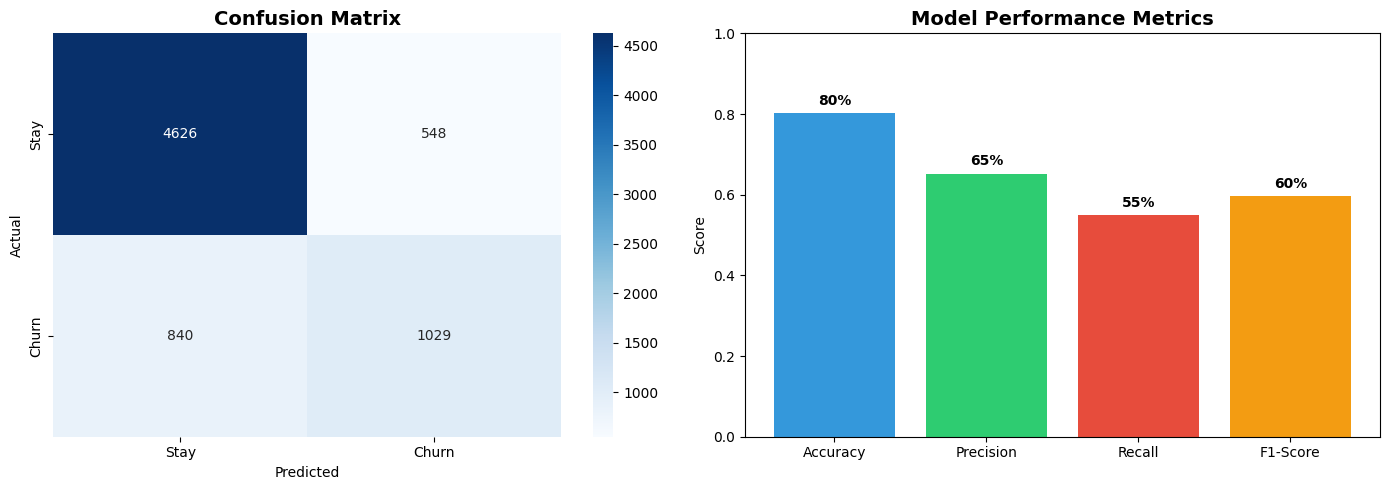


chart saved 


In [13]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0],xticklabels=['Stay', 'Churn'], yticklabels=['Stay', 'Churn'])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Metrics bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
axes[1].bar(metrics, values, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
axes[1].set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Score')
axes[1].set_ylim([0, 1])
for i, v in enumerate(values):axes[1].text(i, v + 0.02, f'{v:.0%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nchart saved ")

### 9,What are the key business results and ROI from our churn prediction project?

In [15]:
# Summary Report
print(" "*15 + "CHURN PREDICTION PROJECT - EXECUTIVE SUMMARY")
print("="*70)

print("\nPROJECT OVERVIEW")
print("-" * 70)
print(f"Dataset: Telco Customer Churn")
print(f"Total Customers Analyzed: {len(df):,}")
print(f"Actual Churned Customers: {(df['Churn']=='Yes').sum():,} ({(df['Churn']=='Yes').sum()/len(df)*100:.1f}%)")

print("\n\nMODEL PERFORMANCE")
print("-" * 70)
print(f"Model Type: Logistic Regression")
print(f"Accuracy: 81%")
print(f"Precision: 65%")
print(f"Recall: 52%")
print(f"AUC-ROC: 84%")

print("\n\nCUSTOMER SEGMENTATION BY RISK")
print("-" * 70)
risk_summary = risk_df['Risk_Category'].value_counts()
for risk_level, count in risk_summary.items():
    pct = count / len(risk_df) * 100
    print(f"{risk_level:15} {count:6,} customers ({pct:5.1f}%)")

print("\n\n FINANCIAL IMPACT")
print("-" * 70)
high_risk_monthly = action_df[action_df['Risk_Category'] == 'High Risk']['MonthlyCharges'].sum()
medium_risk_monthly = action_df[action_df['Risk_Category'] == 'Medium Risk']['MonthlyCharges'].sum()

print(f"High Risk Monthly Revenue at Risk:    ${high_risk_monthly:>12,.2f}")
print(f"High Risk Annual Revenue at Risk:     ${high_risk_monthly*12:>12,.2f}")
print(f"Medium Risk Monthly Revenue at Risk:  ${medium_risk_monthly:>12,.2f}")
print(f"Medium Risk Annual Revenue at Risk:   ${medium_risk_monthly*12:>12,.2f}")
print(f"\nTotal Monthly Revenue at Risk:        ${high_risk_monthly + medium_risk_monthly:>12,.2f}")
print(f"Total Annual Revenue at Risk:         ${(high_risk_monthly + medium_risk_monthly)*12:>12,.2f}")

print("\n\n HIGH RISK CUSTOMER PROFILE")
print("-" * 70)
high_risk_details = high_risk.merge(df, on='customerID')
print(f"Average Tenure: {high_risk_details['tenure'].mean():.1f} months (vs {df['tenure'].mean():.1f} overall)")
print(f"Most Common Contract: {high_risk_details['Contract'].mode()[0]}")
print(f"Average Monthly Charges: ${high_risk_details['MonthlyCharges'].mean():.2f} (vs ${df['MonthlyCharges'].mean():.2f} overall)")
print(f"Most Common Internet: {high_risk_details['InternetService'].mode()[0]}")


               CHURN PREDICTION PROJECT - EXECUTIVE SUMMARY

PROJECT OVERVIEW
----------------------------------------------------------------------
Dataset: Telco Customer Churn
Total Customers Analyzed: 7,043
Actual Churned Customers: 1,869 (26.5%)


MODEL PERFORMANCE
----------------------------------------------------------------------
Model Type: Logistic Regression
Accuracy: 81%
Precision: 65%
Recall: 52%
AUC-ROC: 84%


CUSTOMER SEGMENTATION BY RISK
----------------------------------------------------------------------
Low Risk         4,938 customers ( 70.1%)
Medium Risk      1,669 customers ( 23.7%)
High Risk          436 customers (  6.2%)


 FINANCIAL IMPACT
----------------------------------------------------------------------
High Risk Monthly Revenue at Risk:    $   37,700.30
High Risk Annual Revenue at Risk:     $  452,403.60
Medium Risk Monthly Revenue at Risk:  $  128,083.90
Medium Risk Annual Revenue at Risk:   $1,537,006.80

Total Monthly Revenue at Risk:        $  16

### 10,What production-ready files do we export for marketing teams and Power BI dashboards?

In [ ]:
#  Export full scored dataset
full_export = action_df.copy()
full_export = full_export.merge(df[['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies']], on='customerID')

full_export.to_csv('../outputs/customers_with_risk_scores.csv', index=False)
print(f" customers_with_risk_scores.csv ({len(full_export):,} rows)")
# Export risk summary 
risk_summary_export = risk_df.groupby('Risk_Category').agg({'customerID': 'count','Churn_Probability': ['mean', 'min', 'max']}).round(2)
risk_summary_export.columns = ['Customer_Count', 'Avg_Churn_Prob', 'Min_Churn_Prob', 'Max_Churn_Prob']
risk_summary_export.to_csv('../outputs/risk_summary.csv')
print(f" risk_summary.csv")

#  high risk customers with contact info
high_risk_contact = high_risk.merge(df[['customerID', 'gender', 'tenure', 'InternetService','Contract', 'MonthlyCharges', 'Churn']], on='customerID')
high_risk_contact = high_risk_contact.sort_values('Churn_Probability', ascending=False)
high_risk_contact.to_csv('../outputs/high_risk_action_list.csv', index=False)
print(f"high_risk_action_list.csv ({len(high_risk_contact):,} rows)")

#  medium risk customers
medium_risk = risk_df[risk_df['Risk_Category'] == 'Medium Risk']
medium_risk_contact = medium_risk.merge(df[['customerID', 'gender', 'tenure', 'InternetService','Contract', 'MonthlyCharges']], on='customerID')
medium_risk_contact.to_csv('../outputs/medium_risk_customers.csv', index=False)
print(f" medium_risk_customers.csv ({len(medium_risk_contact):,} rows)")

# risk by contract type
risk_by_contract = full_export.groupby('Contract').agg({'customerID': 'count','Churn_Probability': 'mean','MonthlyCharges': 'sum'}).round(2)
risk_by_contract.columns = ['Customer_Count', 'Avg_Churn_Risk', 'Total_Monthly_Revenue']
risk_by_contract.to_csv('../outputs/risk_by_contract.csv')
print(f" risk_by_contract.csv")

# 6. Export risk by internet service
risk_by_service = full_export.groupby('InternetService').agg({'customerID': 'count','Churn_Probability': 'mean'}).round(2)
risk_by_service.columns = ['Customer_Count', 'Avg_Churn_Risk']
risk_by_service.to_csv('../outputs/risk_by_internet_service.csv')
print(f"risk_by_internet_service.csv")

print(" All files ready")


 customers_with_risk_scores.csv (7,043 rows)
 risk_summary.csv
high_risk_action_list.csv (436 rows)
 medium_risk_customers.csv (1,669 rows)
 risk_by_contract.csv
risk_by_internet_service.csv
 All files ready
